<h1 style="text-align:center;">Workshop Training</h1> 

<h2 style="text-align:center;">LULC Analysis and Classification using Remote Sensing Data with Machine Learning Approach</h2> 

### Section 3: Training Data Manipulation and Deep Learning Model Training

This session is to learn about how the multi-temporal of index images is constructed and preprocesed to be ready-to-analysis for deeep learning model training

First is to declare neccesary properties to specify the raster data

In [1]:
import numpy as np

import matplotlib.pyplot as plt

In [ ]:
#base_path = ''
base_path = 'https://github.com/thanthamky/rs-lc-dl/raw/refs/heads/main/'

## Data Training

This section is to do Deep learning model training. EDA of prepared training data will be shown first before do actual deep learning modeling

You may check the folder `training_data_...` first the see the structure and pattern of trainig data store, and noted that this training data is actual dataset the workflow system you may try to take away later on

In [3]:
def retreive_training_data(training_data_path):
    
    X_list = []
    
    for i in range(1, 9):
        
        X_list.append(np.genfromtxt(f"{training_data_path}/{training_data_path.split('/')[-1]}_{i}.csv", delimiter=','))
    
    y_np = np.genfromtxt(f"{training_data_path}/{training_data_path.split('/')[-1]}_label.csv", delimiter=',')
    
    return np.dstack(X_list).transpose(0,2,1), y_np

Retreive training data as `X` and `y`

In [4]:
X, y = retreive_training_data(base_path+'training_data_doae_sampled_2021_125x7s_52w_8f')

Check the shape of `X` and `y`. You may see that shape of training data is `(sample, feature, timestep)`

In [5]:
X.shape, y.shape

((875, 8, 52), (875,))

Since the labels were numerical encoded, here this is a textual maps and color for visual purpose

In [6]:
class_name = {
    1: 'Water',
    2: 'Urban',
    3: 'Forest',
    4: 'Sugarcane',
    5: 'Rice',
    6: 'Maize',
    7: 'Cassava'
}

class_color = {
    1: 'blue',
    2: 'gray',
    3: 'darkgreen',
    4: 'yellow',
    5: 'lightgreen',
    6: 'orange',
    7: 'magenta'
}

First of all for EDA, checkl the unique value counts to examine balancing if the dataset

In [7]:
values, counts = np.unique(y, return_counts=True)
values, counts

(array([1., 2., 3., 4., 5., 6., 7.]),
 array([125, 125, 125, 125, 125, 125, 125]))

Noted that this training data was cut for training model purpose. Actual training data may have greater than 120k samples.

Plot the time-series of the LULC

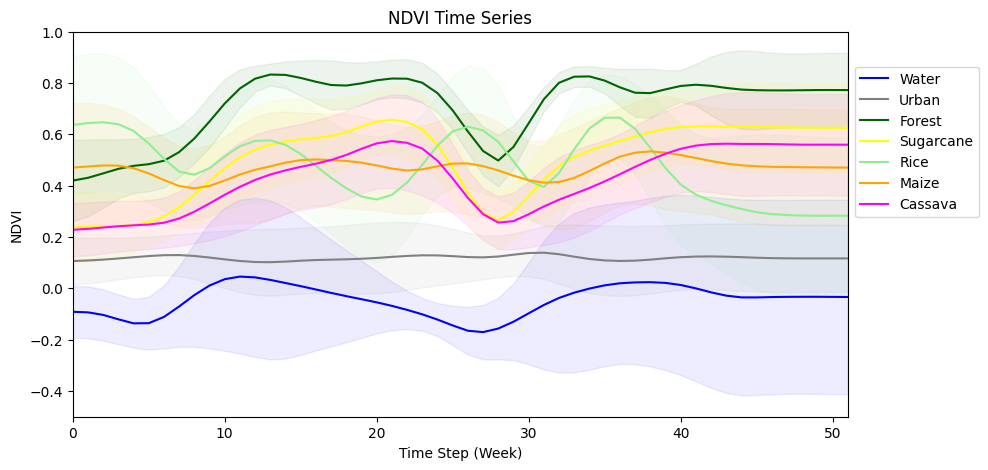

In [8]:
plt.figure(figsize=(10, 5))

for class_code, color in zip(np.unique(y), class_color.values()):

    select_class_code = class_code

    mean_line = X[y == select_class_code][:, 0, :].mean(axis=0)
    std_value = X[y == select_class_code][:, 0, :].std(axis=0)
    fill_upper = mean_line + std_value
    fill_lower = mean_line - std_value

    plt.plot(mean_line, color=color, label=class_name[class_code])
    plt.fill_between(np.arange(len(mean_line)), fill_upper, fill_lower, alpha=.07, color=color)
    
plt.ylim(-0.5, 1)
plt.xlim(0, 51)

plt.title('NDVI Time Series')
plt.xlabel('Time Step (Week)')
plt.ylabel('NDVI')

plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

Nevertheless, taking 52 timesteps (weekly) is not a good idea to workshop for modeling tutorial. we would resample the, into 12 timesteps for help more faster tasking

In [9]:
def decimate(arr, factor=4):
    return arr[:, ::factor][:,:-1]

Try to apply the time resample to check the shape

In [10]:
np.dstack([decimate(X[:, i, :]) for i in range(X.shape[1])]).shape

(875, 12, 8)

stacking the training data gives `(sample, timestep, feature)` however, what we need the datacube shape is `(sample, feature, timestep)`

In [11]:
X_sc = np.dstack([decimate(X[:, i, :]) for i in range(X.shape[1])]).transpose(0, 2, 1)
X_sc.shape

(875, 8, 12)

_**It is okay to use different shape of model input, but this shape is practical for 1-DCNN and 2-DCNN_

## Training Step

Modeling part is need pytorch module tutorial. Please see the `pytorch_tutorial.ipynb` to make understanding

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

from torchsummary import summary

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix

We may prefer processing unit. Please check the capability of GPU-Enabled first before

In [13]:
if torch.cuda.is_available():
    device = 'cuda'
    
elif torch.backends.mps.is_available():
    device = 'mps'
    
else:
    device = 'cpu'
    
print(f'Using device: {device}')

Using device: mps


Finally we choose

In [14]:
device = 'cpu'

We prepared `X` to be `X_sc` (scaled) with 12 timesteps. It is same as normal machine learning workflow but we can keep the multi-dimensional shape of `X_sc` as shape `(sample, feature, timestep)`. Also, `torch` module use different tensor class to be `torch.tensor` not `numpy.ndarray`. However, it is practical same way to use both 

In [15]:
X_sc = torch.from_numpy(X_sc).float()
y = torch.from_numpy(y).long()


`sklearn.model_selection.train_test_split` module is able to be implemented for splitting training and testing set

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size=0.3, stratify=y)

This is more advanced rather torch tutorial. This practice use `DataLoader` to the model train by batches instead of use all samples per epoch. This reduces memory usage of model handling in the workflow and system

In [17]:
train_loader = DataLoader(TensorDataset(X_train, y_train))
test_loader = DataLoader(TensorDataset(X_test, y_test))

Before that torch module rely on numeric class labels to define number of classes in outputs from model feed forward

In [18]:
torch.unique(y_test)

tensor([1, 2, 3, 4, 5, 6, 7])

We use 8 classes since we have labels 0-7 (8 in total).

<br>

This example show 1DCNN model class for modeling. We suppose come up 2 `Conv1d` layer sets before flattening to `Linear` layer of classification

In [58]:
# Define the model
class CNN1DModel(nn.Module):
    
    def __init__(self, input_features, num_classes, timesteps):
        super(CNN1DModel, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=input_features, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(64 * (timesteps // 2), 128)  # Assuming timesteps are halved by pooling
        self.relu3 = nn.ReLU()
        
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

After having template of the model class, compling the model by declaring Loss function and Optimizer function

In [59]:
model = CNN1DModel(input_features=8, num_classes=8, timesteps=12)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model = model.to(device)

Try to forward the model by a simple sample shape to check whether there is any error of the feedforward

In [60]:
model(X_train[:10].to(device))

tensor([[ 0.2129,  1.1064, -2.1774,  0.1080, -0.7144, -0.0217,  0.6402,  0.0710],
        [ 0.1971,  1.2049, -2.2003, -0.0795, -0.7759, -0.0464,  0.8552,  0.1717],
        [ 0.2672,  1.0644, -2.3420, -0.0887, -0.7972,  0.0834,  0.5821,  0.0113],
        [ 0.1964,  1.0137, -2.1127,  0.0335, -0.6774,  0.0361,  0.6035,  0.1054],
        [ 0.3021,  0.9122, -2.2002, -0.0387, -0.6119,  0.0116,  0.5826,  0.0618],
        [ 0.1587,  0.9778, -2.0413, -0.0819, -0.6161,  0.0144,  0.6102,  0.0371],
        [ 0.1802,  1.1460, -2.2001, -0.0864, -0.7425, -0.1679,  0.7324,  0.1986],
        [-0.2003,  0.7790, -2.2465, -0.1007, -0.5754,  0.1034,  0.6912,  0.2983],
        [ 0.1504,  1.1097, -2.3738, -0.0697, -0.7376,  0.0933,  0.8216,  0.1938],
        [ 0.0828,  1.0823, -1.8641, -0.0180, -0.5382,  0.0526,  0.4951,  0.1163]],
       grad_fn=<AddmmBackward0>)

Next is model training job, declare the number of epochs first. The epochs work by feedforward and back-propagation through each batch until full samples, counting as 1 epoch. Training over 50 epochs means do feedforward+backpropagation in all samples in batches for 50 times.

In [61]:
epochs = 50

try training model

In [ ]:
model.train() # Set model as training state

training_loss = []
training_acc = []

for epoch in range(epochs): # Looping over epochs
    
    running_loss = 0.0 # loss of training
    
    total = 0 # total M
    correct = 0 # correct M
    
    for inputs, labels in train_loader: # looping over batches
        
        optimizer.zero_grad() # Set gradients to zero
        
        inputs = inputs.to(device) # move X to device
        labels = labels.to(device) # move y to device
        
        outputs = model(inputs) # predict this batch
        
        loss = criterion(outputs, labels) # calculate loss this batch
        
        loss.backward() # calculate gradients
        
        optimizer.step() # adjust weights

        # sum up the loss
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    
    epoch_loss = running_loss / len(train_loader) # calculate epoch loss
    epoch_acc = 100 * correct / total # calculate epoch accuracy
    
    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc)

    # print epoch loss and accuracy
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}, Acc: {epoch_acc}")


Epoch [1/50], Loss: 0.7727, Acc: 70.58823529411765
Epoch [2/50], Loss: 0.6336, Acc: 75.16339869281046
Epoch [3/50], Loss: 0.5764, Acc: 77.45098039215686
Epoch [4/50], Loss: 0.5190, Acc: 80.71895424836602
Epoch [5/50], Loss: 0.4563, Acc: 82.02614379084967
Epoch [6/50], Loss: 0.4819, Acc: 80.88235294117646
Epoch [7/50], Loss: 0.4378, Acc: 82.3529411764706
Epoch [8/50], Loss: 0.3691, Acc: 84.9673202614379
Epoch [9/50], Loss: 0.4361, Acc: 82.51633986928104
Epoch [10/50], Loss: 0.3407, Acc: 85.29411764705883
Epoch [11/50], Loss: 0.3197, Acc: 86.76470588235294
Epoch [12/50], Loss: 0.2646, Acc: 88.72549019607843
Epoch [13/50], Loss: 0.3085, Acc: 88.72549019607843
Epoch [14/50], Loss: 0.2990, Acc: 88.88888888888889
Epoch [15/50], Loss: 0.2041, Acc: 93.13725490196079
Epoch [16/50], Loss: 0.2501, Acc: 91.99346405228758
Epoch [17/50], Loss: 0.2568, Acc: 91.17647058823529
Epoch [18/50], Loss: 0.3024, Acc: 88.23529411764706
Epoch [19/50], Loss: 0.2289, Acc: 91.01307189542484
Epoch [20/50], Loss: 0.

Visualize the training curve to examine the training steps

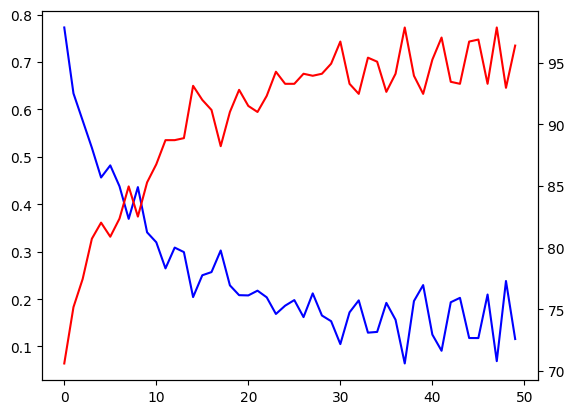

In [84]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(training_loss, color='blue', label='Training Loss')
#ax1.set_ylabel('Loss')

ax2.plot(training_acc, color='red', label='Training Accuracy')
#ax2.set_ylabel('Accuracy')

#ax1.legend(loc='lower right')
#ax2.legend(loc='upper right')

#ax1.set_title('Training Curve')

plt.show()

After training, there should be a testing step. The testing do as same as training but no gradient calculation and no optimization, just predict the outputs

In [85]:

model = model.to('cpu') # Move to model parameters to cpu

model.eval()

with torch.no_grad(): # tell the model that don't calculate gradients
    
    all_labels = []
    all_preds = []
    
    for inputs, labels in test_loader:
    
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

Apply the `classification_report` from `sklearn` to check accuracy

In [86]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        38
           2       0.94      0.87      0.90        38
           3       0.97      1.00      0.99        37
           4       0.58      0.70      0.63        37
           5       0.83      0.89      0.86        38
           6       0.74      0.84      0.78        37
           7       0.62      0.39      0.48        38

    accuracy                           0.81       263
   macro avg       0.81      0.81      0.81       263
weighted avg       0.81      0.81      0.81       263



Confusion matrix should be employed as well as metrics

In [87]:
cm_table = confusion_matrix(all_labels, all_preds)
cm_table

array([[38,  0,  0,  0,  0,  0,  0],
       [ 0, 33,  0,  1,  2,  0,  2],
       [ 0,  0, 37,  0,  0,  0,  0],
       [ 0,  1,  0, 26,  1,  3,  6],
       [ 0,  1,  0,  0, 34,  3,  0],
       [ 0,  0,  0,  3,  2, 31,  1],
       [ 0,  0,  1, 15,  2,  5, 15]])

Visualize the Confusion Matrix

Text(0.5, 1.0, 'Confusion matrix of classification training')

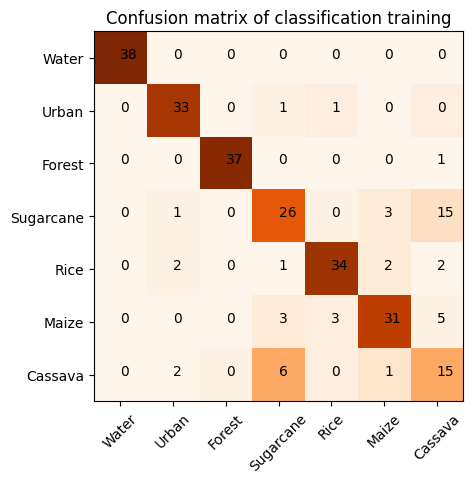

In [88]:
plt.imshow(cm_table, cmap='Oranges')

for i in range(cm_table.shape[0]):
    for j in range(cm_table.shape[1]):
        plt.text(i, j, cm_table[i, j])
        
plt.xticks(np.arange(len(class_name)), list(class_name.values()), rotation=45)
plt.yticks(np.arange(len(class_name)), list(class_name.values()))

plt.title('Confusion matrix of classification training')

This is an example of constructing model for pre-training the classifier using torch. After working with training, we have to save the model. There are several ways to save to model. Most of popular way is to save only weight values into a file. This will export the weights of each layer name into a bunch of numbers into a file by using `model.state_dict()`. It serialize weight maps into a JSON like to object and allow to later loading can re-assign the weights

In [89]:
torch.save(model.state_dict(), 'model_1dcnn_8f12t.pt')

Suppose we would like to retreive the model. The way is to instantiate the model with same configuration and use `model.load_state_dict` with `torch.load` from file the cell output will show match seucesscully

In [90]:
model = CNN1DModel(input_features=8, num_classes=8, timesteps=12)

model.load_state_dict(torch.load('model_1dcnn_8f12t.pt'))

<All keys matched successfully>

To inference to model, we activate `eval()` mode to tell the model being in prediction state (disable dropout, gradients)

In [91]:
model.eval()

CNN1DModel(
  (conv1): Conv1d(8, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu1): ReLU()
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu2): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=384, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=8, bias=True)
)

Create a random input with same shape of model input

In [92]:
 x = torch.rand(10, 8, 12)

forward the model, and get the argmax class

In [93]:
out = model(x)

_, pred = torch.max(out, axis=1)

Here is the result

In [94]:
pred

tensor([3, 3, 3, 6, 3, 4, 6, 4, 3, 3])

## Regularization and Model Tuning

You might see that model we created is the way to use several layers without any additonal tuning. In reality, in large dataset has many problems with _Underfitting_ and _Overfitting_. What we have to do is to tune up the model balancing 2 aspects, __Complexity__ and __Regularization__.

<br>

To understand more about it, _underfitting_ is a phenomenon that model tends to be dumb and cannt perform well on difficult cases despite _overfitting_ which is too smart causing no robustness. 

![](https://miro.medium.com/v2/resize:fit:631/1*AOc1YQUMjIwQrhhGFR9WeQ.png)

Another explanation is about __Bias__ and __Variance__. Bias is a term of _Overfitting_ which model bias to give the output near to larger probabilty to the major class, while variance indicates to the capability to distinguish more varirty of target features

![](https://media.geeksforgeeks.org/wp-content/uploads/20230315100857/ML--Bias-Vs-Variance-(1).png)

To balance this, moderate data scientists add more parameters or layers to increase complexity and add `Dropout` layer to decrease overfitting potential. Dropout is a regularized layer that randomly blind the perceptron nodes to allow only some weights work with the layer. This reduces model bias with simply adding variance term to the model

![](https://miro.medium.com/v2/resize:fit:954/1*U8xAcmXfO-3QaBZiAQykqw.png)

Let's modify something to add more compexity and dropout

In [ ]:
# Define the model
class CNN1DModelReg(nn.Module):
    
    def __init__(self, input_features, num_classes, timesteps):
        super(CNN1DModelReg, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=input_features, out_channels=32, kernel_size=3, padding=1)
        
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        self.maxpool = nn.MaxPool1d(kernel_size=2)

        self.relu = nn.ReLU()
        
        self.flatten = nn.Flatten()
        
        self.dropout = nn.Dropout(0.1)
        
        self.fc1 = nn.Linear(100, 512)  # Assuming timesteps are halved by pooling
        
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        
        x = self.flatten(x)
        
        #print(x.shape)
        
        x = self.fc1(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        
        return x

Then create an instance of the model

In [44]:
model_reg = CNN1DModelReg(input_features=8, num_classes=8, timesteps=12)

Try to feedforward to check whether any error

In [45]:
x = torch.rand(5, 8, 12)

model_reg(x)

torch.Size([5, 384])


tensor([[-0.0244, -0.0335,  0.0457, -0.0063,  0.0386,  0.0251,  0.0706, -0.0309],
        [-0.0379, -0.0382,  0.0568,  0.0104,  0.0413,  0.0066,  0.0725, -0.0391],
        [-0.0421, -0.0377,  0.0498,  0.0082,  0.0349,  0.0241,  0.0815, -0.0415],
        [-0.0343, -0.0276,  0.0475,  0.0076,  0.0447,  0.0208,  0.0722, -0.0406],
        [-0.0376, -0.0380,  0.0434,  0.0068,  0.0404,  0.0177,  0.0841, -0.0398]],
       grad_fn=<AddmmBackward0>)

Bet that you got the error, fix it as instructor guide. Declare the model training property

In [ ]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model_reg.parameters(), lr=0.001)
optimizer = optim.Adam(model_reg.parameters(), lr=0.001)

model_reg = model_reg.to(device)

epochs = 100

Train the model, but this run we will do validation during training and print out the training and validation at the same time

In [ ]:
training_loss = []
training_acc = []

val_loss = []
val_acc = []

for epoch in range(epochs): # Looping over epochs
    
    # ------------------------------TRAINING----------------------------------
    running_loss = 0.0 # loss of training
    
    total = 0 # total M
    correct = 0 # correct M
    
    model_reg.train()
    
    for inputs, labels in train_loader: # looping over batches
        
        optimizer.zero_grad() # Set gradients to zero
        
        inputs = inputs.to(device) # move X to device
        labels = labels.to(device) # move y to device
        
        outputs = model_reg(inputs) # predict this batch
        
        loss = criterion(outputs, labels) # calculate loss this batch
        
        loss.backward() # calculate gradients
        
        optimizer.step() # adjust weights

        # sum up the loss
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    
    epoch_loss = running_loss #/ len(train_loader) # calculate epoch loss
    epoch_acc = 100 * correct / total # calculate epoch accuracy
    
    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc)
    
    # ------------------ VALIDATION --------------------------------
    
    running_loss = 0.0 # loss of training
    
    total = 0 # total M
    correct = 0 # correct M
    
    model_reg.eval()
    
    for inputs, labels in test_loader: # looping over batches
        
        optimizer.zero_grad() # Set gradients to zero
        
        inputs = inputs.to(device) # move X to device
        labels = labels.to(device) # move y to device
        
        outputs = model_reg(inputs) # predict this batch
        
        loss = criterion(outputs, labels) # calculate loss this batch

        # sum up the loss
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    
    epoch_loss = running_loss #/ len(train_loader) # calculate epoch loss
    epoch_acc = 100 * correct / total # calculate epoch accuracy
    
    val_loss.append(epoch_loss)
    val_acc.append(epoch_acc)
    
 
    # print epoch loss and accuracy
    print(f"Epoch [{epoch + 1}/{epochs}], train loss: {training_loss[-1] / len(train_loader):.4f}, train acc: {training_acc[-1]},  --- val loss: {val_loss[-1] / len(test_loader):.4f}, val acc: {val_acc[-1]},")


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch [1/100], train loss: 1.7875, train acc: 31.69934640522876,  --- val loss: 1.5565, val acc: 49.049429657794676,
Epoch [2/100], train loss: 1.4141, train acc: 47.05882352941177,  --- val loss: 1.2938, val acc: 52.851711026615966,
Epoch [3/100], train loss: 1.2660, train acc: 49.673202614379086,  --- val loss: 1.1202, val acc: 57.41444866920152,
Epoch [4/100], train loss: 1.1715, train acc: 54.57516339869281,  --- val loss: 1.1183, val acc: 53.99239543726236,
Epoch [5/100], train loss: 1.0649, train acc: 57.02614379084967,  --- val loss: 0.9419, val acc: 58.17490494296578,
Epoch [6/100], train loss: 0.9793, train acc: 61.928104575163395,  --- val loss: 0.8129, val acc: 67.68060836501901,
Epoch [7/100], train loss: 0.9239, train acc: 62.091503267973856,  --- val loss: 0.9540, val acc: 61.97718631178707,
Epoch [8/100], train loss: 0.9405, train acc: 62.254901960784316,  --- val loss: 0.8950, val acc: 65.39923954372624,
Epoch [9/100], train loss: 0.8731, train acc: 64.2156862745098,  -

Plot the training curve

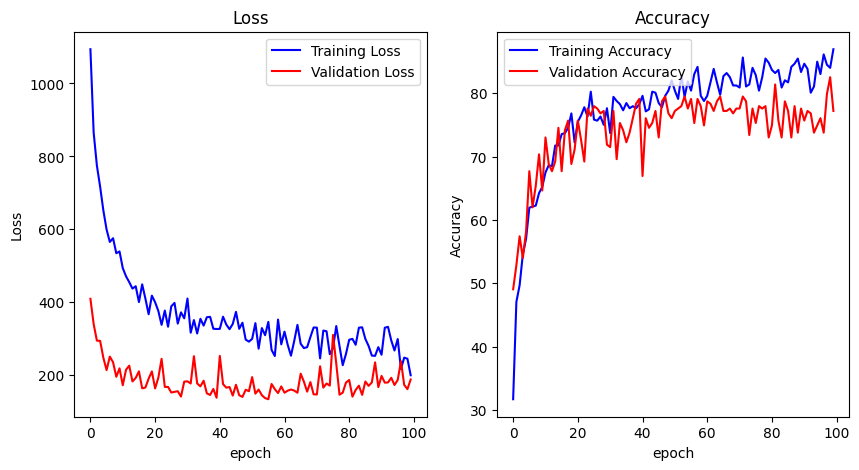

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


axs[0].plot(training_loss, color='blue', label='Training Loss')
axs[0].plot(val_loss, color='red', label='Validation Loss')
axs[0].set_title('Loss')
axs[0].legend(loc='upper right')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('epoch')



axs[1].plot(training_acc, color='blue', label='Training Accuracy')
axs[1].plot(val_acc, color='red', label='Validation Accuracy')
axs[1].set_title('Accuracy')
axs[1].legend(loc='upper left')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('epoch')


plt.show()

Save the model

In [39]:
torch.save(model_reg.state_dict(), 'model_1dcnn-reg_8f12t.pt')